# Demo - Conditional Gaussianization Flow

In [1]:
# @title Install Packages
# %%capture
try:
    import sys, os
    from pyprojroot import here

    # spyder up to find the root
    root = here(project_files=[".here"])

    # append to path
    sys.path.append(str(root))
except ModuleNotFoundError:
    import os

    os.system("pip install objax chex")
    os.system("pip install git+https://github.com/IPL-UV/rbig_jax.git#egg=rbig_jax")

In [3]:
# jax packages
import jax
import jax.numpy as jnp
from jax.config import config

# import chex
config.update("jax_enable_x64", False)

import objax
import chex
import numpy as np
from functools import partial

# library functions
from rbig_jax.transforms.parametric.mixture.logistic import InitMixtureLogisticCDF
from rbig_jax.transforms.parametric.mixture.gaussian import InitMixtureGaussianCDF
from rbig_jax.transforms.logit import InitLogitTransform
from rbig_jax.transforms.inversecdf import InitInverseGaussCDF
from rbig_jax.transforms.parametric.householder import InitHouseHolder
from distrax._src.bijectors.sigmoid import Sigmoid
from distrax._src.bijectors.inverse import Inverse


KEY = jax.random.PRNGKey(seed=123)

# logging
import tqdm
import wandb

# plot methods
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import corner
from IPython.display import HTML

sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)

%load_ext lab_black
%matplotlib inline
%load_ext autoreload
%autoreload 2

## Demo Data

In [18]:
import tensorflow_datasets as tfds
import tensorflow as tf
from sklearn import datasets
import tensorflow_datasets as tfds
from typing import Iterator, Mapping
import numpy as np

Batch = Mapping[str, np.ndarray]


def load_dataset(
    n_train: int,
    batch_size: int,
    seed: int,
    n_samples: int = 2_000,
    noise: float = 0.05,
) -> Iterator[Batch]:
    X, y = datasets.make_moons(n_samples=n_samples, noise=noise, random_state=seed)
    ds = tf.data.Dataset.from_tensor_slices((X, y))
    ds = ds.shuffle(buffer_size=10 * batch_size)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=5)
    ds = ds.repeat()
    return iter(tfds.as_numpy(ds))

In [19]:
# train/valid dataset loaders
# wandb_logger.config.batch_size = 128
n_init_samples = 5_000
n_train = 5_000

init_ds = load_dataset(n_init_samples, n_init_samples, 123)

# demo batch
init_X, init_Y = next(init_ds)

In [20]:
init_Y.shape, init_X.shape

((2000,), (2000, 2))

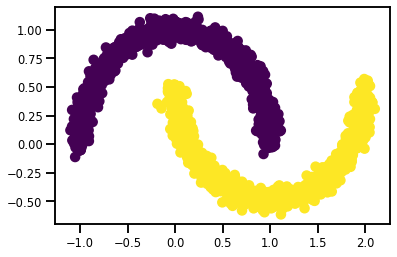

In [22]:
fig, ax = plt.subplots()

ax.scatter(init_X[:, 0], init_X[:, 1], c=init_Y)
plt.show()

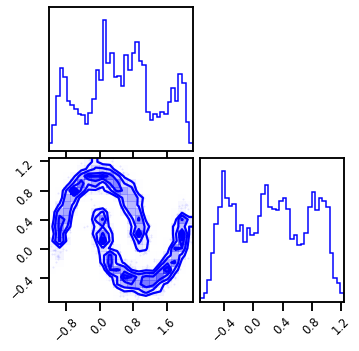

In [13]:
# plot data
fig = corner.corner(init_X, color="blue", hist_bin_factor=2)

## DataLoader

In [27]:
from typing import Optional
from chex import Array
from einops import rearrange

PRNGKey = Array


def prepare_data(batch: Batch) -> Array:

    # select image from tfds
    batch = batch[0].astype(jnp.float32)
    label = batch[1].astype(jnp.float32)

    return batch, label

## Model

In [29]:
from rbig_jax.models.gaussflow import init_default_gf_model

# initialization data
n_init_samples = 10_000

init_ds = load_dataset(n_init_samples, n_init_samples, 100)
init_ds = next(init_ds)
X_init, Y_init = prepare_data(init_ds)
X_init, Y_init = np.array(X_init), np.array(Y_init)


# marginal uniformization
mixture = "logistic"
n_components = 10
init_mixcdf = "gmm"

# inverse cdf
inverse_cdf = "logistic"

# rotation transformation
n_reflections = 4
init_rotation = "random"

# nn params
n_blocks = 6

In [30]:
# init model
gf_model = init_default_gf_model(
    shape=X_init.shape[1:],
    X=X_init,
    n_blocks=n_blocks,
    mixture=mixture,
    n_components=n_components,
    init_mixcdf=init_mixcdf,
    inverse_cdf=inverse_cdf,
    init_rotation=init_rotation,
    n_reflections=n_reflections,
)

Initializing - Block: 6 | Layer 17: 100%|██████████| 6/6 [00:03<00:00,  1.84it/s]


### Plot Initial Layers

In [31]:
%%time

# X_g = gf_model.forward(X_init)
# X_g, X_ldj = gf_model.forward_and_log_det(X_init)

gf_model.score(X_init)

CPU times: user 785 ms, sys: 35.6 ms, total: 821 ms
Wall time: 758 ms


DeviceArray(1.8094007, dtype=float32)

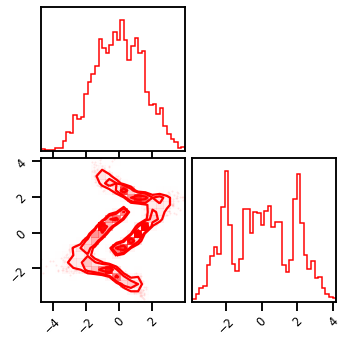

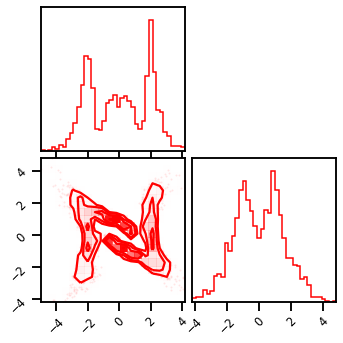

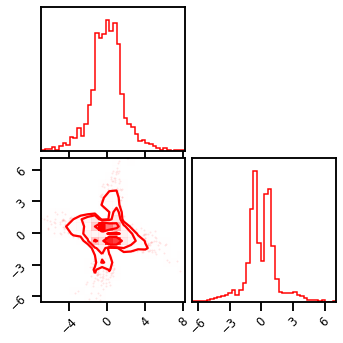

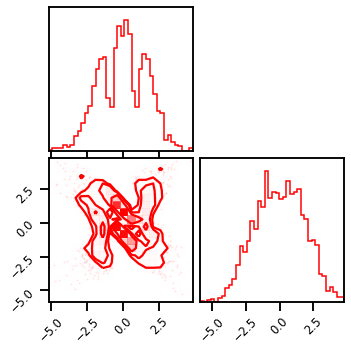

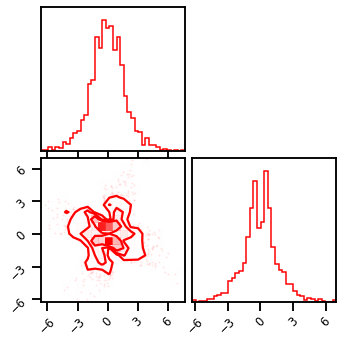

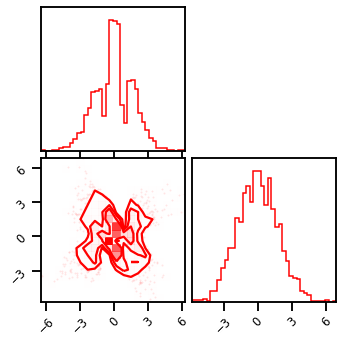

In [32]:
X_g = X_init.copy()

for ibijector in gf_model.bijectors:

    X_g = ibijector.forward(X_g)

    if ibijector.name == "HouseHolder":
        fig = corner.corner(np.array(X_g), color="red", hist_bin_factor=2)

### Classification Model

In [38]:
import flax
from flax import linen as nn

In [43]:
Y_init.shape, X_init.shape

((2,), (2000, 2))

In [45]:
2 * Y_init.shape[0]

4

In [66]:
params["params"]["kernel"].shape

(4, 1)

In [92]:
from flax import struct
from typing import Callable, Tuple
from chex import Array


@struct.dataclass
class ConditionalModel:
    params: dict
    model: Callable = struct.field(pytree_node=False)

    def forward(self, inputs) -> Tuple[Array, Array]:
        # forward pass for params
        outputs = self.model.apply(self.params, inputs)

        # split params
        split = outputs.shape[0] // 2

        # compute means and log stds
        means = outputs[..., :split]
        log_stds = outputs[..., split:]

        return means, log_stds

In [93]:
# create model
model = nn.Dense(features=2)
# create dummy variable
rng, *model_rng = jax.random.split(KEY, 3)
X_dummy = jax.random.normal(model_rng[0], (2,))
params = model.init(model_rng[1], X_dummy)

# initialize conditional model
cond_model = ConditionalModel(params=params, model=model)

# forward pass
means, log_stds = cond_model.forward(Y_init)
means, log_stds

(DeviceArray([0.99094796], dtype=float32),
 DeviceArray([2.0395823], dtype=float32))

In [40]:
model

Dense(
    # attributes
    features = 5
    use_bias = True
    dtype = float32
    precision = None
    kernel_init = init
    bias_init = zeros
)

#### Training

In [13]:
from chex import dataclass


def loss_fn(model: dataclass, batch: Batch) -> Array:

    # negative log likelihood loss
    nll_loss = model.score(batch)

    return nll_loss


@jax.jit
def eval_fn(model: dataclass, batch: Batch) -> Array:

    # negative log likelihood loss
    nll_loss = model.score(batch)

    return nll_loss

In [14]:
nll_loss = loss_fn(gf_model, demo_batch)
print(f"Initial NLL Loss (Train): {nll_loss:.4f}")
nll_loss = eval_fn(gf_model, demo_batch)
print(f"Initial NLL Loss (Train): {nll_loss:.4f}")

Initial NLL Loss (Train): 6.8372
Initial NLL Loss (Train): 6.8372


### Optimizer

In [15]:
import optax

# optimizer params
epochs = 5_000  # 12_000
eval_frequency = 50
learning_rate = 1e-3

# intialize optimizer
# optimizer = optax.adam(learning_rate=learning_rate)
optimizer = optax.chain(
    optax.clip_by_global_norm(0.25),
    #     optax.clip(1.0),
    optax.adam(learning_rate, b1=0.9, b2=0.99, eps=1e-5),
)

# intialize optimizer state
opt_state = optimizer.init(gf_model)

### Train Step

In [16]:
from typing import Tuple, Any

OptState = Any


@jax.jit
def update(
    params: dataclass, opt_state: OptState, batch: Batch
) -> Tuple[dataclass, OptState]:
    """Single SGD update step."""
    # calculate the loss AND the gradients
    loss, grads = jax.value_and_grad(loss_fn)(params, batch)

    # update the gradients
    updates, new_opt_state = optimizer.update(grads, opt_state)

    # update the parameters
    new_params = optax.apply_updates(params, updates)

    # return loss AND new opt_state
    return new_params, new_opt_state, loss

### Train Loop

In [17]:
train_ds = load_dataset(n_train, 128, 123)
valid_ds = load_dataset(2_000, 128, 123 + 100)


metrics = {
    "train_step": list(),
    "train_loss": list(),
    "valid_step": list(),
    "valid_loss": list(),
}


eval_loss = 0.0

In [18]:
# %%wandb

import tqdm


with tqdm.trange(epochs) as pbar:
    for step in pbar:
        gf_model, opt_state, loss = update(gf_model, opt_state, next(train_ds))

        pbar.set_description(f"Train Loss: {loss:.4f} | Valid Loss: {eval_loss:.4f}")
        #         wandb.log({"train_loss": float(loss), "training_step": step})
        metrics["train_step"].append(step)
        metrics["train_loss"].append(loss)

        if step % eval_frequency == 0:
            eval_loss = eval_fn(gf_model, next(valid_ds))

            pbar.set_description(
                f"Train Loss: {loss:.4f} | Valid Loss: {eval_loss:.4f}"
            )
            #             wandb.log({"validation_loss": float(eval_loss), "training_step": step})
            metrics["valid_step"].append(step)
            metrics["valid_loss"].append(eval_loss)

Train Loss: 5.7684 | Valid Loss: 5.6949: 100%|██████████| 5000/5000 [00:51<00:00, 96.18it/s] 


### Results

#### Losses

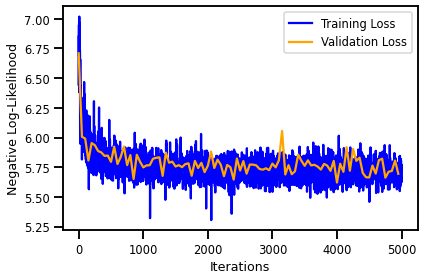

In [19]:
fig, ax = plt.subplots()
ax.plot(
    metrics["train_step"], metrics["train_loss"], label="Training Loss", color="blue"
)
ax.plot(
    metrics["valid_step"],
    metrics["valid_loss"],
    label="Validation Loss",
    color="orange",
)
ax.set(
    xlabel="Iterations", ylabel="Negative Log-Likelihood",
)
plt.legend()
plt.tight_layout()
plt.show()

#### Latent Space

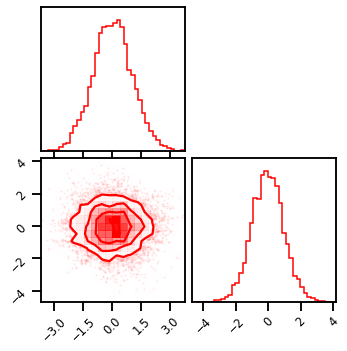

CPU times: user 953 ms, sys: 31.7 ms, total: 984 ms
Wall time: 882 ms


In [20]:
%%time
n_eval_samples = 10_000
eval_ds = load_dataset(n_eval_samples, n_eval_samples, 200)
eval_ds =next(eval_ds)
X_trans = gf_model.forward(eval_ds)

fig = corner.corner(np.array(X_trans), color="Red", hist_bin_factor=2)
plt.show()

#### Inverse Transform

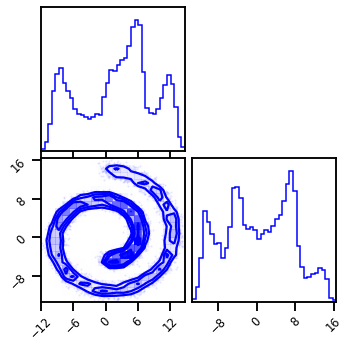

CPU times: user 55.8 s, sys: 4.53 s, total: 1min
Wall time: 15.6 s


In [21]:
%%time

X_approx = gf_model.inverse(X_trans)

fig = corner.corner(np.array(X_approx), color="Blue", hist_bin_factor=2)
plt.show()

### Log Probability

#### Plot: Original Density

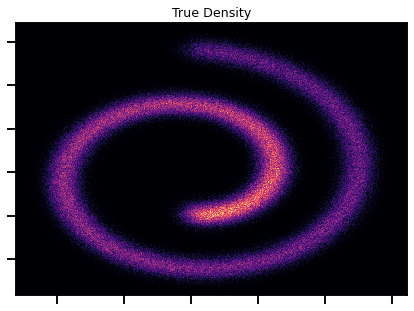

In [22]:
from matplotlib import cm

cmap = cm.magma
# Original Density
n_samples = 1_000_000
noise = 0.8
seed = 42
ds_plot = PlaneDataset(n_samples=n_samples, noise=noise, seed=seed)
X_plot = ds_plot[:]


fig, ax = plt.subplots(figsize=(7, 5))
h = ax.hist2d(
    X_plot[:, 0], X_plot[:, 1], bins=512, cmap=cmap, density=True,  # vmin=0.0, vmax=1.0
)
ax.set_title("True Density")
ax.set(
    xlim=[X_plot[:, 0].min(), X_plot[:, 0].max()],
    ylim=[X_plot[:, 1].min(), X_plot[:, 1].max()],
    xticklabels="",
    yticklabels="",
)
plt.show()

In [23]:
%%time

from rbig_jax.data import generate_2d_grid

# general grid points
xyinput = generate_2d_grid(X_init, 500, buffer=0.2)

# calculate log probability
X_log_prob = gf_model.score_samples(xyinput)

CPU times: user 4.63 s, sys: 522 ms, total: 5.16 s
Wall time: 2.35 s


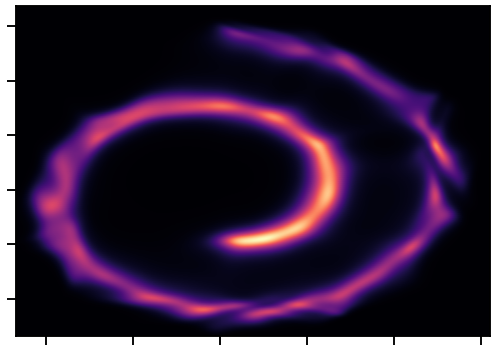

In [24]:
# # Original Density
# n_samples = 1_000_000
# ds_plot = PlaneDataset(n_samples=n_samples, noise=noise, seed=seed)
# X_plot = ds_plot[:]

# Estimated Density
cmap = cm.magma  # "Reds"
probs = jnp.exp(X_log_prob)
# probs = np.clip(probs, 0.0, 1.0)
# probs = np.clip(probs, None, 0.0)


cmap = cm.magma  # "Reds"

fig, ax = plt.subplots(figsize=(7, 5))

h1 = ax.scatter(
    xyinput[:, 0],
    xyinput[:, 1],
    s=1,
    c=probs,
    cmap=cmap,
    #     vmax=0.01,  # vmin=0.0, vmax=1.0
)
ax.set(
    xlim=[xyinput[:, 0].min(), xyinput[:, 0].max()],
    ylim=[xyinput[:, 1].min(), xyinput[:, 1].max()],
    xticklabels="",
    yticklabels="",
)


plt.tight_layout()
plt.show()

### Sampling

In [25]:
# %%time
# n_gen_samples = 100_000
# pred_batch_size = 10_000
# X_samples = []
# for _ in tqdm.trange(n_gen_samples // pred_batch_size):

#     X_samples.append(final_bijector.sample(seed=123, n_samples=pred_batch_size))

In [29]:
%%time

n_gen_samples = 100_000

X_samples = gf_model.sample(seed=123, n_samples=n_gen_samples)

CPU times: user 6min 51s, sys: 3.86 s, total: 6min 55s
Wall time: 1min 4s


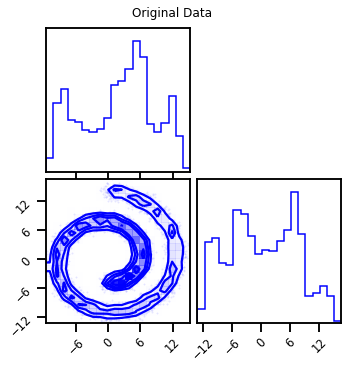

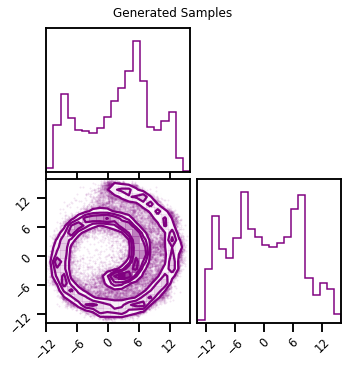

In [30]:
fig = corner.corner(np.array(X_init), color="blue", label="Original Data")
fig.suptitle("Original Data")
plt.show()

fig2 = corner.corner(np.array(X_samples), color="purple")
fig2.suptitle("Generated Samples")
plt.show()

## Each Layer

#### Trained Model

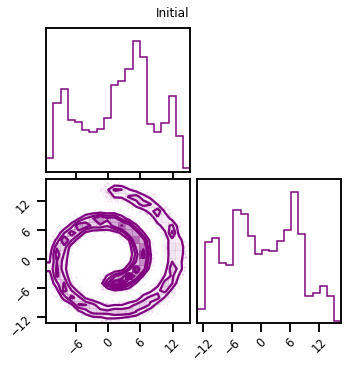

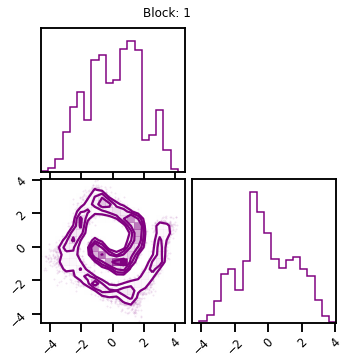

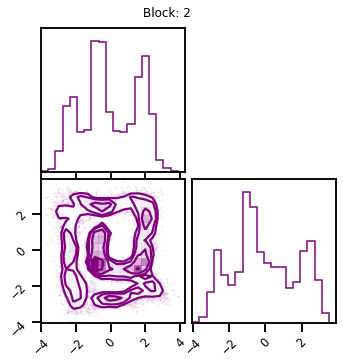

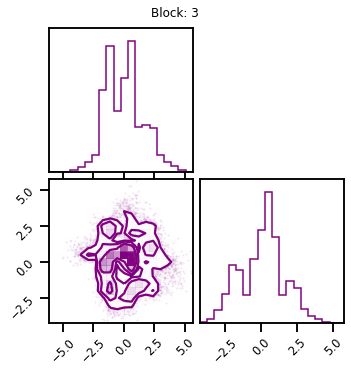

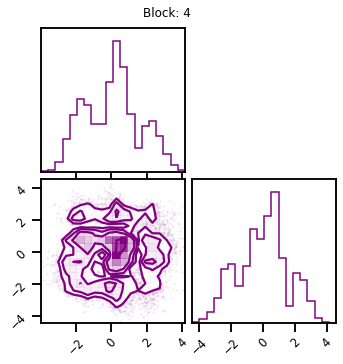

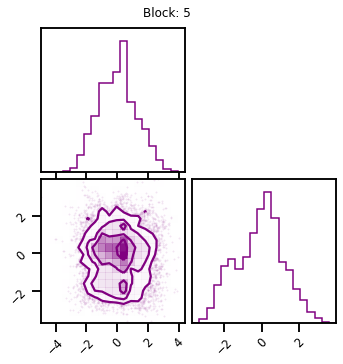

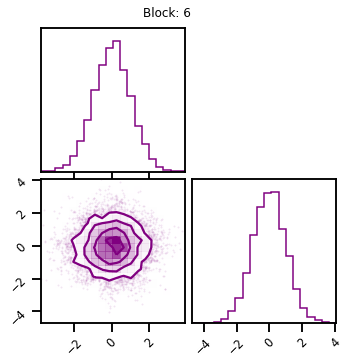

In [31]:
X_g = X_init.copy()

fig = corner.corner(X_g, color="purple")
fig.suptitle("Initial")

plt.show()

for ilayer, ibijector in enumerate(gf_model.bijectors):

    X_g = ibijector.forward(X_g)

    if ibijector.name == "HouseHolder":
        fig = corner.corner(np.array(X_g), color="purple")
        fig.suptitle(f"Block: {(ilayer+1)//3}")
        plt.show()

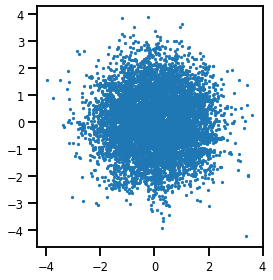

In [140]:
fig, ax = plt.subplots()
ax.scatter(X_g[:, 0], X_g[:, 1], s=3)
ax.set_aspect("equal", "box")
plt.tight_layout()

## Saving/Loading Model

In [226]:
import pickle

#### Save Model

In [227]:
import joblib

joblib.dump(gf_model, "gf_model.pickle")

['gf_model.pickle']

#### Load Model

In [228]:
rbig_model_loaded = joblib.load("gf_model.pickle")